In [1]:
# Cell 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score
import numpy as np
import matplotlib.pyplot as plt
import random


# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')


Device: cuda


In [2]:
# Cell 2: Paths and Data Loading
train_img_folder = '../Penyisihan_Hology_DataMining/train'  # Update with the path to your train folder
csv_file = '../Penyisihan_Hology_DataMining/train.csv'  # Update with the path to your train.csv

# Load train.csv
train_df = pd.read_csv(csv_file)


In [3]:
# Cell 3: Data Augmentation and Preprocessing
IMG_SIZE = (224, 224)

data_transforms_train = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.01, contrast=0.01, saturation=(0.6, 1), hue=0.01)], p=0.4),
    transforms.RandomApply([transforms.RandomRotation(degrees=5)], p=0.3),  # 20% chance of rotation
    #transforms.RandomApply([transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0))], p=0.1),  # 10% chance
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.05, p=0.1)], p=0.3),  # 30% chance
    transforms.RandomApply([transforms.RandomGrayscale(p=0.1)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# Preprocessing for validation
data_transforms_val = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [4]:
# Cell 4: Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['id']
        jenis_label = self.dataframe.iloc[idx]['jenis']
        warna_label = self.dataframe.iloc[idx]['warna']

        img_path = None
        try:
            img_extensions = ['.jpg', '.JPG', '.png']  # Handle multiple extensions
            for ext in img_extensions:
                potential_path = os.path.join(self.img_dir, f"{img_id}{ext}")
                if os.path.exists(potential_path):
                    img_path = potential_path
                    break
            if img_path:
                image = Image.open(img_path).convert('RGB')
            else:
                print(f"Image {img_id} not found.")
                image = Image.new('RGB', IMG_SIZE)

        except Exception as e:
            print(f"Error loading image {img_id}: {str(e)}")
            image = Image.new('RGB', IMG_SIZE)

        if self.transform:
            image = self.transform(image)

        return image, jenis_label, warna_label


In [5]:
# Cell 5: Data Splitting and Sampler Setup
# Split the data into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Compute class weights for 'jenis' and 'warna' based on their frequencies
def compute_class_weights(dataframe, column):
    class_counts = dataframe[column].value_counts().sort_index().values
    class_weights = 1. / class_counts
    return class_weights

# Get weights for 'jenis' and 'warna'
jenis_weights = compute_class_weights(train_df, 'jenis')
warna_weights = compute_class_weights(train_df, 'warna')

# Compute sample weights for each row in the dataframe
sample_weights = []
for idx in range(len(train_df)):
    jenis_label = train_df.iloc[idx]['jenis']
    warna_label = train_df.iloc[idx]['warna']
    sample_weight = jenis_weights[jenis_label] + warna_weights[warna_label]
    sample_weights.append(sample_weight)

# Create a sampler for balanced dataset
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


In [6]:
# Cell 6: Dataset and Dataloader
# Create dataset and dataloaders
train_dataset = CustomImageDataset(train_df, train_img_folder, transform=data_transforms_train)
val_dataset = CustomImageDataset(val_df, train_img_folder, transform=data_transforms_val)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
# Cell 7: Model Setup
# Load EfficientNetB0 pretrained on ImageNet
model = models.efficientnet_b0(pretrained=True)

# Modify the classifier to output 2 classes for 'jenis' and 5 classes for 'warna'
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    #nn.BatchNorm1d(512),  # Adding Batch Normalization after the first Linear layer
    nn.ReLU(),
    #nn.Dropout(p=0.5),  # Adding Dropout with a probability of 0.5
    nn.Linear(512, 7)  # 2 for jenis + 5 for warna
)

# Move model to GPU if available
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Implement Scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.09)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)


C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Cell 8: Model Training and Evaluation Functions
def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels_jenis = []
    all_labels_warna = []

    with torch.no_grad():
        for images, jenis_labels, warna_labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            jenis_outputs = outputs[:, :2].cpu().numpy()
            warna_outputs = outputs[:, 2:].cpu().numpy()

            all_preds.append(np.concatenate([jenis_outputs, warna_outputs], axis=1))
            all_labels_jenis.append(jenis_labels.cpu().numpy())
            all_labels_warna.append(warna_labels.cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels_jenis = np.hstack(all_labels_jenis)
    all_labels_warna = np.hstack(all_labels_warna)

    preds_jenis = np.argmax(all_preds[:, :2], axis=1)
    preds_warna = np.argmax(all_preds[:, 2:], axis=1)

    accuracy_jenis = accuracy_score(all_labels_jenis, preds_jenis)
    accuracy_warna = accuracy_score(all_labels_warna, preds_warna)
    
    precision_jenis = precision_score(all_labels_jenis, preds_jenis, average='macro')
    precision_warna = precision_score(all_labels_warna, preds_warna, average='macro')
    
    recall_jenis = recall_score(all_labels_jenis, preds_jenis, average='macro')
    recall_warna = recall_score(all_labels_warna, preds_warna, average='macro')

    f1_jenis = f1_score(all_labels_jenis, preds_jenis, average='macro')
    f1_warna = f1_score(all_labels_warna, preds_warna, average='macro')

    hamming = hamming_loss(np.hstack([all_labels_jenis, all_labels_warna]), np.hstack([preds_jenis, preds_warna]))
    
    jaccard_jenis = jaccard_score(all_labels_jenis, preds_jenis, average='macro')
    jaccard_warna = jaccard_score(all_labels_warna, preds_warna, average='macro')

    return {
        'accuracy_jenis': accuracy_jenis,
        'accuracy_warna': accuracy_warna,
        'precision_jenis': precision_jenis,
        'precision_warna': precision_warna,
        'recall_jenis': recall_jenis,
        'recall_warna': recall_warna,
        'f1_jenis': f1_jenis,
        'f1_warna': f1_warna,
        'hamming_loss': hamming,
        'jaccard_jenis': jaccard_jenis,
        'jaccard_warna': jaccard_warna
    }

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    metrics_list = []
    best_val_loss = float('inf')
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, jenis_labels, warna_labels in train_loader:
            images, jenis_labels, warna_labels = images.to(device), jenis_labels.to(device), warna_labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            jenis_outputs = outputs[:, :2]
            warna_outputs = outputs[:, 2:]

            jenis_loss = criterion(jenis_outputs, jenis_labels)
            warna_loss = criterion(warna_outputs, warna_labels)
            loss = jenis_loss + warna_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        with torch.no_grad():
            for images, jenis_labels, warna_labels in val_loader:
                images, jenis_labels, warna_labels = images.to(device), jenis_labels.to(device), warna_labels.to(device)
                outputs = model(images)
                jenis_outputs = outputs[:, :2]
                warna_outputs = outputs[:, 2:]

                jenis_loss = criterion(jenis_outputs, jenis_labels)
                warna_loss = criterion(warna_outputs, warna_labels)
                val_loss += (jenis_loss + warna_loss).item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        metrics = evaluate_model(model, val_loader)
        metrics_list.append(metrics)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()
            print(f"New best model found at epoch {epoch+1}, saving the model...")

        scheduler.step()

    if best_model_wts is not None:
        torch.save(best_model_wts, './base5_result/best_multilabel_final.pth')
        print("Best model saved.")
    else:
        print("No improvement during training.")

    return train_losses, val_losses, metrics_list


In [9]:
# Cell 9: Plotting Losses and Metrics
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_metrics(metrics_list):
    accuracy_jenis = [m['accuracy_jenis'] for m in metrics_list]
    accuracy_warna = [m['accuracy_warna'] for m in metrics_list]
    f1_jenis = [m['f1_jenis'] for m in metrics_list]
    f1_warna = [m['f1_warna'] for m in metrics_list]

    plt.figure(figsize=(10, 6))
    plt.plot(accuracy_jenis, label='Jenis Accuracy')
    plt.plot(accuracy_warna, label='Warna Accuracy')
    plt.plot(f1_jenis, label='Jenis F1 Score')
    plt.plot(f1_warna, label='Warna F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Scores')
    plt.title('Accuracy and F1 Score for Jenis and Warna')
    plt.legend()
    plt.show()


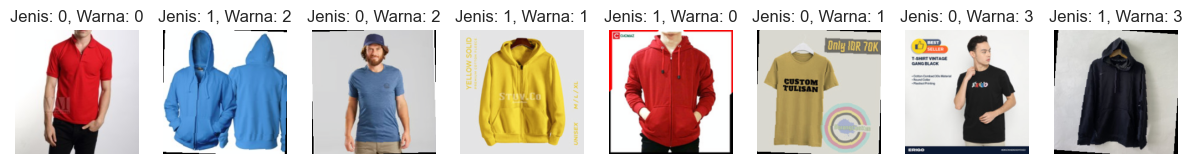

In [10]:
# Cell 10: Visualize Augmented Images
def visualize_augmented_images(loader, num_images=8):
    batch = next(iter(loader))
    images, jenis_labels, warna_labels = batch

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values for valid image display

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Jenis: {jenis_labels[i]}, Warna: {warna_labels[i]}')
        plt.axis('off')
    plt.show()

# Call this function before the training loop to visualize the augmented images
visualize_augmented_images(train_loader)


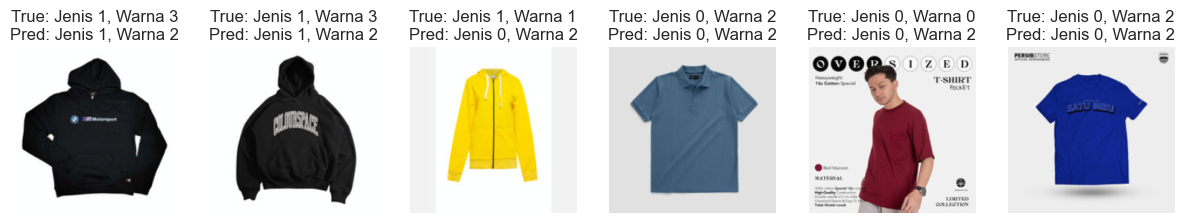

In [11]:
# Cell 11: Visualize Predictions
# Cell 11: Visualize Random Predictions
def visualize_random_predictions(model, loader, num_images=6):
    model.eval()
    
    # Get a random batch of images from the loader
    random_batch = random.randint(0, len(loader)-1)
    for i, batch in enumerate(loader):
        if i == random_batch:
            images, true_jenis_labels, true_warna_labels = batch
            break

    images = images.to(device)

    with torch.no_grad():
        outputs = model(images)

    preds_jenis = torch.argmax(outputs[:, :2], dim=1).cpu().numpy()
    preds_warna = torch.argmax(outputs[:, 2:], dim=1).cpu().numpy()

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'True: Jenis {true_jenis_labels[i]}, Warna {true_warna_labels[i]}\n'
                  f'Pred: Jenis {preds_jenis[i]}, Warna {preds_warna[i]}')
        plt.axis('off')
    plt.show()

# Call this function after training to visualize random predictions
visualize_random_predictions(model, val_loader)


Epoch [1/12], Train Loss: 2.0733, Val Loss: 1.7508
New best model found at epoch 1, saving the model...
Epoch [2/12], Train Loss: 1.3775, Val Loss: 0.9588
New best model found at epoch 2, saving the model...
Epoch [3/12], Train Loss: 0.6591, Val Loss: 0.3631
New best model found at epoch 3, saving the model...
Epoch [4/12], Train Loss: 0.2487, Val Loss: 0.2725
New best model found at epoch 4, saving the model...
Epoch [5/12], Train Loss: 0.1555, Val Loss: 0.2064
New best model found at epoch 5, saving the model...
Epoch [6/12], Train Loss: 0.1424, Val Loss: 0.1336
New best model found at epoch 6, saving the model...
Epoch [7/12], Train Loss: 0.0807, Val Loss: 0.1644
Epoch [8/12], Train Loss: 0.0736, Val Loss: 0.1412
Epoch [9/12], Train Loss: 0.0850, Val Loss: 0.1452
Epoch [10/12], Train Loss: 0.0419, Val Loss: 0.1425
Epoch [11/12], Train Loss: 0.0696, Val Loss: 0.0989
New best model found at epoch 11, saving the model...
Epoch [12/12], Train Loss: 0.0652, Val Loss: 0.1509
Best model sa

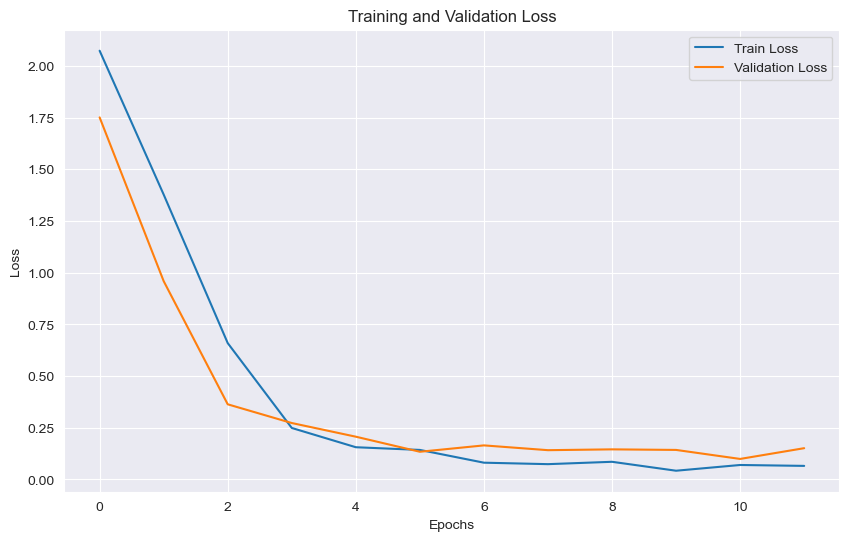

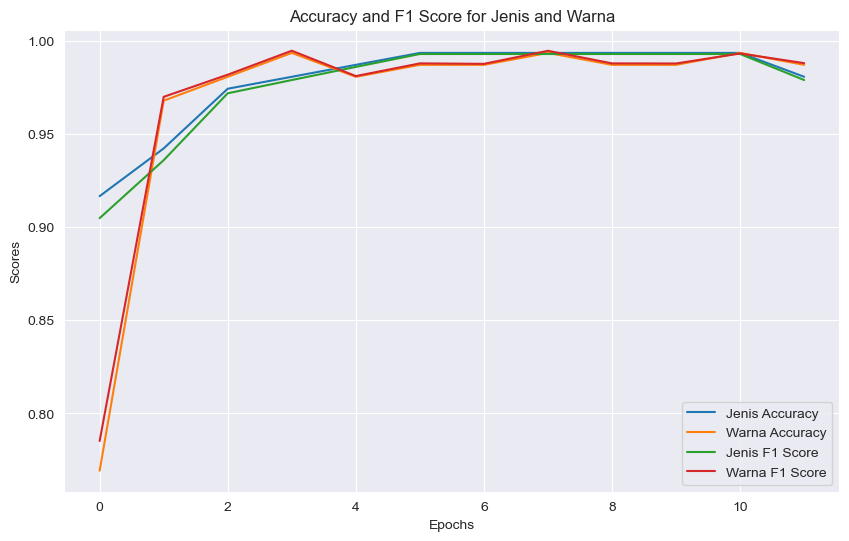

In [12]:
# Cell 12: Training the Model and Visualizing Results
train_losses, val_losses, metrics_list = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=12
)

# Plot the results
plot_losses(train_losses, val_losses)
plot_metrics(metrics_list)


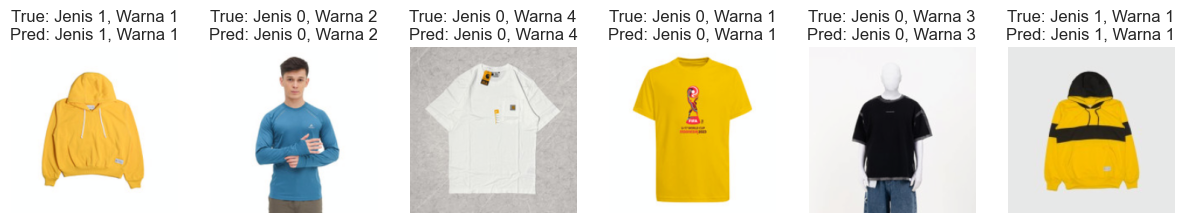

In [13]:
# Cell 13: Load Fine-tuned Model and Visualize Predictions

def load_fine_tuned_model(model_path, model):
    # Load the fine-tuned model weights from the .pth file
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

def visualize_fine_tuned_predictions(model, loader, num_images=6):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Get a random batch of images from the loader
    random_batch = random.randint(0, len(loader)-1)
    for i, batch in enumerate(loader):
        if i == random_batch:
            images, true_jenis_labels, true_warna_labels = batch
            break

    images = images.to(device)

    with torch.no_grad():
        # Get the predictions from the fine-tuned model
        outputs = model(images)

    # Get predicted classes
    preds_jenis = torch.argmax(outputs[:, :2], dim=1).cpu().numpy()
    preds_warna = torch.argmax(outputs[:, 2:], dim=1).cpu().numpy()

    # Plotting the images with true labels and predicted labels
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        img = images[i].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, C) format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img = np.clip(img, 0, 1)  # Clip to ensure valid image range

        # Create the subplot for each image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'True: Jenis {true_jenis_labels[i]}, Warna {true_warna_labels[i]}\n'
                  f'Pred: Jenis {preds_jenis[i]}, Warna {preds_warna[i]}')
        plt.axis('off')

    # Display all images with predictions
    plt.show()

# Load the fine-tuned model from the saved .pth file
fine_tuned_model_path = './base5_result/best_multilabel_b5_model.pth'
model = load_fine_tuned_model(fine_tuned_model_path, model)

# Visualize predictions using the fine-tuned model
visualize_fine_tuned_predictions(model, val_loader)

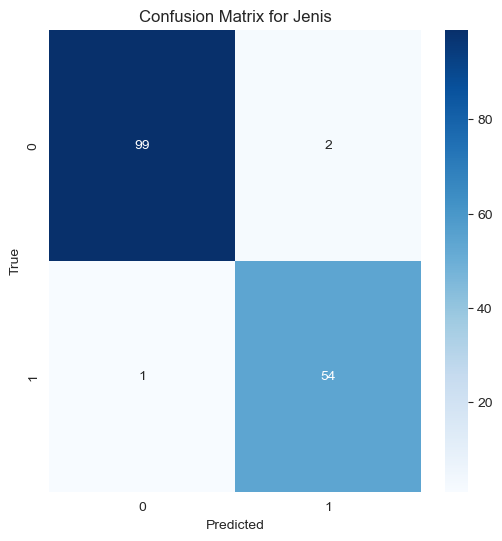

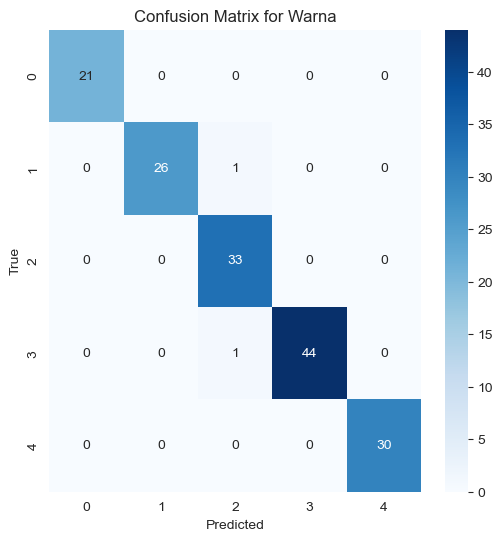

In [14]:
# Cell 14: Confusion Matrix Visualization for 'Jenis' and 'Warna' Labels
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true_labels, pred_labels, label_name):
    cm = confusion_matrix(true_labels, pred_labels)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.title(f'Confusion Matrix for {label_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_and_plot_confusion_matrix(model, loader):
    model.eval()
    true_jenis_labels_list = []
    true_warna_labels_list = []
    preds_jenis_list = []
    preds_warna_list = []

    with torch.no_grad():
        for images, true_jenis_labels, true_warna_labels in loader:
            images = images.to(device)
            outputs = model(images)

            # Get predicted classes
            preds_jenis = torch.argmax(outputs[:, :2], dim=1).cpu().numpy()
            preds_warna = torch.argmax(outputs[:, 2:], dim=1).cpu().numpy()

            # Collect all true and predicted labels
            true_jenis_labels_list.extend(true_jenis_labels.numpy())
            true_warna_labels_list.extend(true_warna_labels.numpy())
            preds_jenis_list.extend(preds_jenis)
            preds_warna_list.extend(preds_warna)

    # Plot confusion matrix for 'jenis'
    plot_confusion_matrix(true_jenis_labels_list, preds_jenis_list, label_name='Jenis')

    # Plot confusion matrix for 'warna'
    plot_confusion_matrix(true_warna_labels_list, preds_warna_list, label_name='Warna')

# Evaluate and plot confusion matrix for fine-tuned model
evaluate_and_plot_confusion_matrix(model, val_loader)


In [15]:
import torch
from torchvision import transforms
import pandas as pd
from PIL import Image
import os
import numpy as np

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = models.efficientnet_b0(pretrained=False)  # Initialize model architecture
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Linear(512, 7)  # 2 for 'jenis' and 5 for 'warna'
)
model.load_state_dict(torch.load('./base5_result/best_multilabel_final.pth'))  # Load weights
model = model.to(device)
model.eval()  # Set to evaluation mode

# Folder for test images
test_img_folder = '../Penyisihan_Hology_DataMining/test'

C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gabri\anaconda3\envs\workenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
import os
from PIL import Image
import torch
from torchvision import transforms


# Image transformations
IMG_SIZE = (224, 224)
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for pre-trained models
])

# Load test images from folder for a specific range of image IDs
def load_test_images_from_folder(folder, start_id=778, end_id=1111):
    images = []
    img_ids = []

    for img_id in range(start_id, end_id + 1):
        # Try jpg first, then png if jpg is not available
        img_filename_jpg = f"{img_id}.jpg"
        img_filename_png = f"{img_id}.png"
        
        img_path_jpg = os.path.join(folder, img_filename_jpg)
        img_path_png = os.path.join(folder, img_filename_png)

        # Check if the image exists and load it
        if os.path.exists(img_path_jpg):
            img_path = img_path_jpg
        elif os.path.exists(img_path_png):
            img_path = img_path_png
        else:
            print(f"Image with ID {img_id} not found in jpg or png format.")
            continue  # Skip this ID if no image is found
        
        try:
            image = Image.open(img_path).convert('RGB')  # Open image and convert to RGB
            image = data_transforms(image)  # Apply transformations
            images.append(image)
            img_ids.append(img_id)
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            continue  # Skip the image if there's an error

    if not images:
        raise ValueError("No images were loaded. Please check the test image folder.")
    
    return torch.stack(images), img_ids  # Return tensor and corresponding image IDs

# Example usage
test_images, test_img_ids = load_test_images_from_folder(test_img_folder, start_id=778, end_id=1111)
test_images = test_images.to(device)


In [17]:
with torch.no_grad():
    outputs = model(test_images)

# Split the predictions for 'jenis' and 'warna'
jenis_predictions = torch.argmax(outputs[:, :2], dim=1).cpu().numpy()  # First 2 outputs for 'jenis'
warna_predictions = torch.argmax(outputs[:, 2:], dim=1).cpu().numpy()  # Next 5 outputs for 'warna'


In [19]:
# Create a DataFrame to store the results
result_df = pd.DataFrame({
    'id': test_img_ids,  # Use the extracted IDs from filenames
    'jenis': jenis_predictions,
    'warna': warna_predictions
})

# Save the results to CSV
result_df.to_csv('./base5_result/predict_label_final.csv', index=False)

print("Predictions saved to 'test_predictions2.csv'.")


Predictions saved to 'test_predictions2.csv'.
